<a href="https://colab.research.google.com/github/LonghuaHu/deep-learning/blob/master/mnist_0315.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import h5py 
#data
f = h5py.File('/content/drive/My Drive/Colab Notebooks/new_quaternionImages.mat','r') 

X = f['quaternionImages'][:]
#data = data.T
print(X.shape)

#lable
f = h5py.File('/content/drive/My Drive/Colab Notebooks/new_quaternionImagesLabels.mat','r') 
y = f['quaternionImagesLabels'][:]
y = y.T
print(y.shape)



(10000, 12, 14, 14)
(10000, 1)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 12, 14, 14) (2000, 12, 14, 14) (8000, 1) (2000, 1)


In [0]:
#data[0,7,0,0]

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3],1)
#training_labels = training_labels[0]
y_train.astype(int)
y_test.astype(int)
print('Number of training examples: ' + str(X_train.shape[0]))
print('Training images shape:' + str(X_train.shape))
print('Training labels shape:' + str(y_train.shape))
print('Test images shape:' + str(X_test.shape))
print('Test labels shape:' + str(y_test.shape))

Number of training examples: 8000
Training images shape:(8000, 12, 14, 14, 1)
Training labels shape:(8000, 1)
Test images shape:(2000, 12, 14, 14, 1)
Test labels shape:(2000, 1)


In [11]:
import os
import tensorflow as tf
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [0]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

In [67]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv3D(8, (3,3,3), activation='relu', input_shape=(12, 14, 14, 1)))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 2, 2)))
model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Conv3D(16, (1,3,3), activation='relu'))
#model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
#model.add(tf.keras.layers.BatchNormalization())


#FC Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 10, 12, 12, 8)     224       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 9, 6, 6, 8)        0         
_________________________________________________________________
batch_normalization_v1_11 (B (None, 9, 6, 6, 8)        32        
_________________________________________________________________
flatten_11 (Flatten)         (None, 2592)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               331904    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 332,289
Trainable params: 332,273
Non-trainable params: 16
_________________________________________________________________


In [68]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0003),
              metrics=['acc'])

history1 = model.fit(X_train, y_train, epochs=50, verbose=1)
test_loss = model.evaluate(X_test, y_test)


#model.fit(X_train, y_train, epochs=30)
#test_loss = model.evaluate(X_test, y_test)

#model.fit(X_train, y_train, epochs=10,
#          validation_data=(X_test, y_test),
#          callbacks=[TrainValTensorBoard(write_graph=False)])

Epoch 1/50
8000/8000 [==============================] - 2s 303us/sample - loss: 0.2600 - acc: 0.9186
Epoch 2/50
8000/8000 [==============================] - 2s 261us/sample - loss: 0.1128 - acc: 0.9643
Epoch 3/50
8000/8000 [==============================] - 2s 261us/sample - loss: 0.0860 - acc: 0.9720
Epoch 4/50
8000/8000 [==============================] - 2s 258us/sample - loss: 0.0590 - acc: 0.9796
Epoch 5/50
8000/8000 [==============================] - 2s 259us/sample - loss: 0.0529 - acc: 0.9811
Epoch 6/50
8000/8000 [==============================] - 2s 261us/sample - loss: 0.0423 - acc: 0.9859
Epoch 7/50
8000/8000 [==============================] - 2s 258us/sample - loss: 0.0357 - acc: 0.9869
Epoch 8/50
8000/8000 [==============================] - 2s 261us/sample - loss: 0.0294 - acc: 0.9904
Epoch 9/50
8000/8000 [==============================] - 2s 262us/sample - loss: 0.0218 - acc: 0.9914
Epoch 10/50
8000/8000 [==============================] - 2s 258us/sample - loss: 0.0185 - a

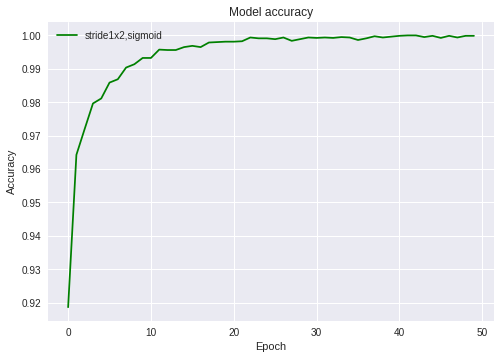

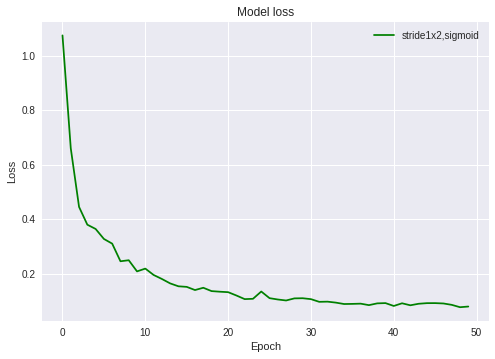

In [69]:
# Plot training accuracy values
plt.plot(history1.history['acc'], color='green', label='stride1x2,sigmoid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.plot(history1.history['loss'], color='green', label='stride1x2,sigmoid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()




In [70]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv3D(8, (3,3,3), activation='relu', input_shape=(12, 14, 14, 1)))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Conv3D(16, (1,3,3), activation='relu'))
#model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
#model.add(tf.keras.layers.BatchNormalization())


#FC Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 10, 12, 12, 8)     224       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 6, 6, 8)        0         
_________________________________________________________________
batch_normalization_v1_12 (B (None, 5, 6, 6, 8)        32        
_________________________________________________________________
flatten_12 (Flatten)         (None, 1440)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               184448    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 184,833
Trainable params: 184,817
Non-trainable params: 16
_________________________________________________________________


In [71]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0003),
              metrics=['acc'])

history2 = model.fit(X_train, y_train, epochs=50, verbose=1)
test_loss = model.evaluate(X_test, y_test)


#model.fit(X_train, y_train, epochs=30)
#test_loss = model.evaluate(X_test, y_test)

#model.fit(X_train, y_train, epochs=10,
#          validation_data=(X_test, y_test),
#          callbacks=[TrainValTensorBoard(write_graph=False)])

Epoch 1/50
8000/8000 [==============================] - 2s 302us/sample - loss: 0.1915 - acc: 0.9290
Epoch 2/50
8000/8000 [==============================] - 2s 254us/sample - loss: 0.0877 - acc: 0.9691
Epoch 3/50
8000/8000 [==============================] - 2s 253us/sample - loss: 0.0692 - acc: 0.9744
Epoch 4/50
8000/8000 [==============================] - 2s 254us/sample - loss: 0.0551 - acc: 0.9810
Epoch 5/50
8000/8000 [==============================] - 2s 253us/sample - loss: 0.0430 - acc: 0.9847
Epoch 6/50
8000/8000 [==============================] - 2s 256us/sample - loss: 0.0356 - acc: 0.9875
Epoch 7/50
8000/8000 [==============================] - 2s 257us/sample - loss: 0.0289 - acc: 0.9904
Epoch 8/50
8000/8000 [==============================] - 2s 255us/sample - loss: 0.0290 - acc: 0.9904
Epoch 9/50
8000/8000 [==============================] - 2s 255us/sample - loss: 0.0230 - acc: 0.9915
Epoch 10/50
8000/8000 [==============================] - 2s 255us/sample - loss: 0.0199 - a

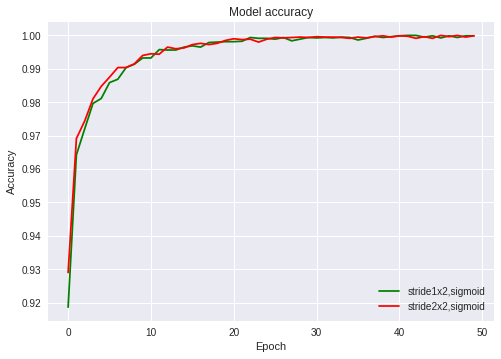

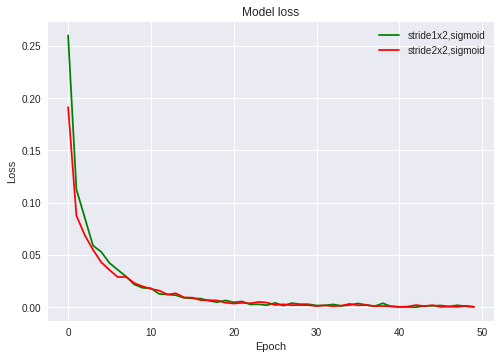

In [72]:
# Plot training accuracy values
plt.plot(history1.history['acc'], color='green', label='stride1x2,sigmoid')
plt.plot(history2.history['acc'], color='red', label='stride2x2,sigmoid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.plot(history1.history['loss'], color='green', label='stride1x2,sigmoid')
plt.plot(history2.history['loss'], color='red', label='stride2x2,sigmoid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [73]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv3D(8, (3,3,3), activation='relu', input_shape=(12, 14, 14, 1)))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 2, 2)))
model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Conv3D(16, (1,3,3), activation='relu'))
#model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
#model.add(tf.keras.layers.BatchNormalization())


#FC Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(1, activation='tanh'))

model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 10, 12, 12, 8)     224       
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 9, 6, 6, 8)        0         
_________________________________________________________________
batch_normalization_v1_13 (B (None, 9, 6, 6, 8)        32        
_________________________________________________________________
flatten_13 (Flatten)         (None, 2592)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               331904    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 332,289
Trainable params: 332,273
Non-trainable params: 16
_________________________________________________________________


In [74]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0003),
              metrics=['acc'])

history3 = model.fit(X_train, y_train, epochs=50, verbose=1)
test_loss = model.evaluate(X_test, y_test)


#model.fit(X_train, y_train, epochs=30)
#test_loss = model.evaluate(X_test, y_test)

#model.fit(X_train, y_train, epochs=10,
#          validation_data=(X_test, y_test),
#          callbacks=[TrainValTensorBoard(write_graph=False)])

Epoch 1/50
8000/8000 [==============================] - 3s 315us/sample - loss: 1.5144 - acc: 0.8764
Epoch 2/50
8000/8000 [==============================] - 2s 262us/sample - loss: 0.7146 - acc: 0.9383
Epoch 3/50
8000/8000 [==============================] - 2s 264us/sample - loss: 0.5983 - acc: 0.9501
Epoch 4/50
8000/8000 [==============================] - 2s 263us/sample - loss: 0.5328 - acc: 0.9574
Epoch 5/50
8000/8000 [==============================] - 2s 262us/sample - loss: 0.5286 - acc: 0.9564
Epoch 6/50
8000/8000 [==============================] - 2s 263us/sample - loss: 0.5046 - acc: 0.9551
Epoch 7/50
8000/8000 [==============================] - 2s 267us/sample - loss: 0.4684 - acc: 0.9651
Epoch 8/50
8000/8000 [==============================] - 2s 265us/sample - loss: 0.3427 - acc: 0.9750
Epoch 9/50
8000/8000 [==============================] - 2s 264us/sample - loss: 0.3543 - acc: 0.9731
Epoch 10/50
8000/8000 [==============================] - 2s 264us/sample - loss: 0.2838 - a

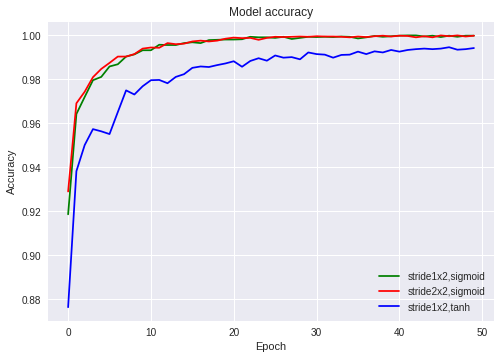

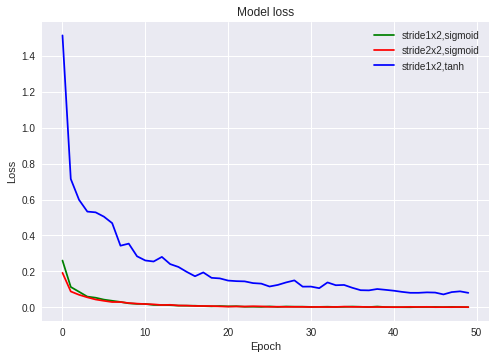

In [75]:
# Plot training accuracy values
plt.plot(history1.history['acc'], color='green', label='stride1x2,sigmoid')
plt.plot(history2.history['acc'], color='red', label='stride2x2,sigmoid')
plt.plot(history3.history['acc'], color='blue', label='stride1x2,tanh')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.plot(history1.history['loss'], color='green', label='stride1x2,sigmoid')
plt.plot(history2.history['loss'], color='red', label='stride2x2,sigmoid')
plt.plot(history3.history['loss'], color='blue', label='stride1x2,tanh')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


